In [30]:
#Gerando os arquivos para cada caso mas omitindo a cada run

#Bibliotecas:
import numpy as np
import pandas as pd
from qutip import *
import csv 
import latex

import matplotlib.pyplot as plt 
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": "18",
    "font.serif": ["Times New Roman"]})
import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=14) 
import matplotlib.gridspec as gridspec
from palettable.colorbrewer.qualitative import Set1_5

In [31]:
#Parâmetros (defino o que parace no Hamiltoniano):
 
Nat=1    #caso para 1 átomo    
kappa = 1.0    #taxa de dissipação da cavidade
g = 0.1*kappa/np.sqrt(Nat)    #força de interação/constante de acoplamento
#frequência de Rabi do campo de controle (omegac > omegap para satisfazer o EIT, 
#essa desigualdade não pode ser muito grande, ultrapassando a largura do estado vestido)
epsilon = np.sqrt(0.001)*kappa    #1 fóton na cavidade com 1.0*kappa
omegac = 1.0*kappa
Delta1 = 0.0*kappa           
Delta2 = 0.0*kappa    #ressonante (delta2 = 0)
DeltaP_list = np.linspace(-2.5,2.5,201)*kappa
     
gamma = 1.0    #taxa de dissipação do átomo (espontâneo)
gamma_13 = 0.5*gamma
gamma_23 = 0.5*gamma

N = 6    #número de estados Focks na cavidade (truncamento)

tlist = np.linspace(0,100,100)/kappa

In [32]:
#Estados ( |k> = (N,k-1) , N úmero total de estados):

state1 = basis(3,0)
state2 = basis(3,1)
state3 = basis(3,2) 

#Operadores (S representa o sigma - sigma_nm = |n><m|
#- simgma_nm=tensor(qeye(N),staten*statem.dag())):

S11 = tensor(qeye(N),state1*state1.dag())
S22 = tensor(qeye(N),state2*state2.dag()) 
S31 = tensor(qeye(N),state3*state1.dag())
S13 = tensor(qeye(N),state1*state3.dag())
S32 = tensor(qeye(N),state3*state2.dag())
S23 = tensor(qeye(N),state2*state3.dag())
S33 = tensor(qeye(N),state3*state3.dag())

#operador de aniquilação dos fótons (destrói uma estação do campo)
a = tensor(destroy(N),qeye(3))  


#Operadores de colapso:

c_ops_cav = np.sqrt(kappa)*a 

c_ops_atom_13 = np.sqrt(gamma_13)*S13

c_ops_atom_23 = np.sqrt(gamma_23)*S23

#Dissipação:

c_ops_list = [c_ops_cav, c_ops_atom_13, c_ops_atom_23]

In [33]:
trans_ss_list = []

for i in range(len(DeltaP_list)):
    
    DeltaP = DeltaP_list[i]
    
    
    #Hamiltoniano: 

    H = Delta1*S33 + (Delta1-Delta2)*S22 + DeltaP*S11 - DeltaP*a.dag()*a + (g*a*S31 + omegac*S32 + epsilon*a + g*a.dag()*S13 + omegac*S23 + epsilon*a.dag())


    #Evolução temporal: equação mestra

    psi0 = tensor(basis(N,0), state2)

    output = mesolve(H,psi0,tlist,c_ops_list,[a.dag()*a])

    trans_ss = output.expect[0]
    
    trans_ss_list.append(trans_ss[-1]/((4*epsilon**2)/kappa**2))    #[-1] última componente

In [34]:
#pré-plot da etapa de geração de dados para a cavidade vazia
plt.plot(DeltaP_list,trans_ss_list)

In [35]:
#Parâmetros a serem colocados e forma de salvar os arquivos:
#(Código feito para rodar três vezes)

#CEIT:
#omegac=2*kappa, gamma23=gamma13=0.5*kappa, psi0 = tensor(basis(N,0), state2)
output_data = np.vstack((DeltaP_list,trans_ss_list))
file_data_store("peak_transmission.dat", output_data.T, numtype = "real", numformat = "decimal", sep = " ")
        
#Átomo de dois níveis:
#omegac=0.0, gamma23=0.0, gamma13=0.5*kappa, psi0 = tensor(basis(N,0), state1)
#output_data = np.vstack((DeltaP_list,trans_ss_list))
#file_data_store("atomo_2niveis.dat", output_data.T, numtype = "real", numformat = "decimal", sep = " ")

#Cavidade vazia:
#omegac=0.0, gamma23=gamma13=0.5*kappa, psi0 = tensor(basis(N,0), state2)
#output_data = np.vstack((DeltaP_list,trans_ss_list))
#file_data_store("cavidade_vazia.dat", output_data.T, numtype = "real", numformat = "decimal", sep = " ")

In [36]:
#Importando os arquivos:

Peak_dados = np.loadtxt("peak_transmission.dat") 
Delta_list = Peak_dados[:,0]  #toma as linhas da primeira coluna
Peak_list = Peak_dados[:,1]   ##toma as linhas da segunda coluna


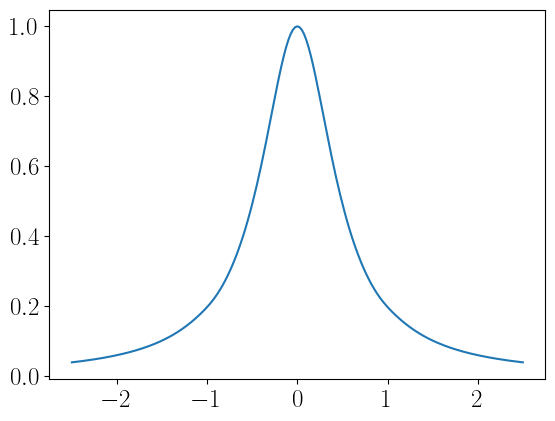

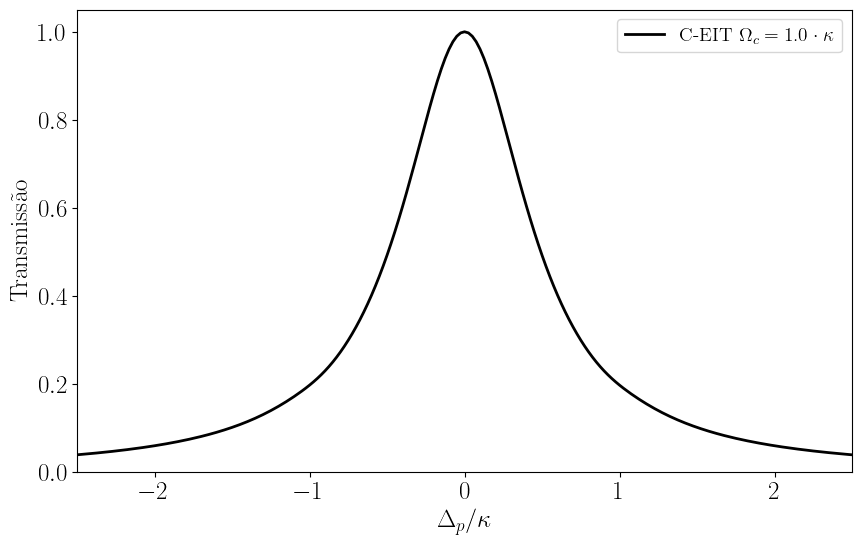

In [37]:
#Plot final

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(Delta_list, Peak_list, color = "black", linewidth = 2)
ax1.set_xlabel("$\Delta_p/\kappa$")
ax1.set_ylabel("Transmissão")
ax1.legend([r"C-EIT $\Omega_c=1.0\cdot\kappa$"]) 
plt.xlim(-2.5,2.5)
plt.ylim(0, 1.05*np.max(Peak_list))
plt.savefig("EIT_peak_transmission.jpeg")
plt.show()